## Load data

In [342]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [343]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
# algo = "reverse_hybrid"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [344]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

merged_df.shape

(1062, 30)

In [345]:
# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

## Clinical Analysis

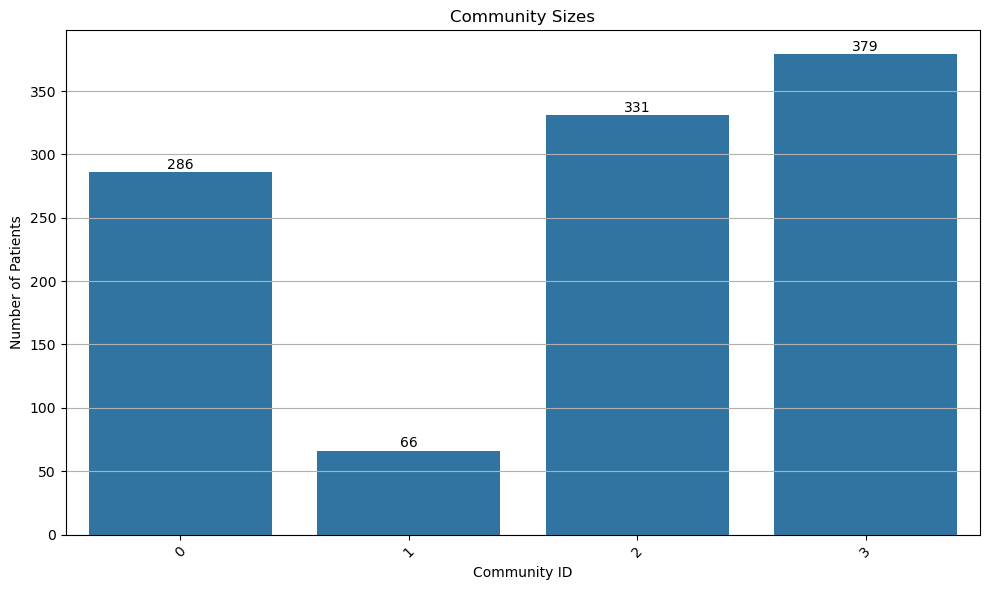

In [346]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_community_sizes(community_df)

In [347]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
print_overlapping_nodes(community_df)

Number of overlapping patients: 54
Overlapping patients and their community memberships:
  PatientId: P-CRC-0004 -> Communities: [1, 2]
  PatientId: P-CRC-0008 -> Communities: [1, 2]
  PatientId: P-CRC-0010 -> Communities: [1, 2]
  PatientId: P-CRC-0012 -> Communities: [1, 2]
  PatientId: P-CRC-0013 -> Communities: [1, 2]
  PatientId: P-CRC-0014 -> Communities: [1, 2]
  PatientId: P-DFCI-5027 -> Communities: [1, 2]
  PatientId: P-DFCI-5035 -> Communities: [1, 2]
  PatientId: P-DFCI-5049 -> Communities: [1, 2]
  PatientId: P-DFCI-5066 -> Communities: [1, 2]
  PatientId: P-DFCI-5068 -> Communities: [1, 2]
  PatientId: P-DFCI-5075 -> Communities: [1, 2]
  PatientId: P-DFCI-5095 -> Communities: [1, 2]
  PatientId: P-DFCI-5098 -> Communities: [1, 2]
  PatientId: P-DFCI-5105 -> Communities: [1, 2]
  PatientId: P-DFCI-5115 -> Communities: [1, 2]
  PatientId: P-DFCI-5129 -> Communities: [1, 2]
  PatientId: P-DFCI-5139 -> Communities: [1, 2]
  PatientId: P-DFCI-5143 -> Communities: [1, 2]
  Pat

In [348]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.violinplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

🔍 Age, Sex distribution per community:

             count       mean        std   min   25%   50%    75%   max
communityId                                                            
0            286.0  66.234266  11.698749  35.0  59.0  66.0  75.00  94.0
1             66.0  60.272727   9.748444  37.0  54.0  60.5  66.75  84.0
2            331.0  61.135952  10.761447  19.0  54.0  62.0  68.50  86.0
3            379.0  62.796834  11.437819  31.0  55.0  64.0  70.00  92.0

🔹 Sex distribution:

SEX            Female      Male
communityId                    
0            0.286713  0.713287
1            0.363636  0.636364
2            0.335347  0.664653
3            0.416887  0.583113


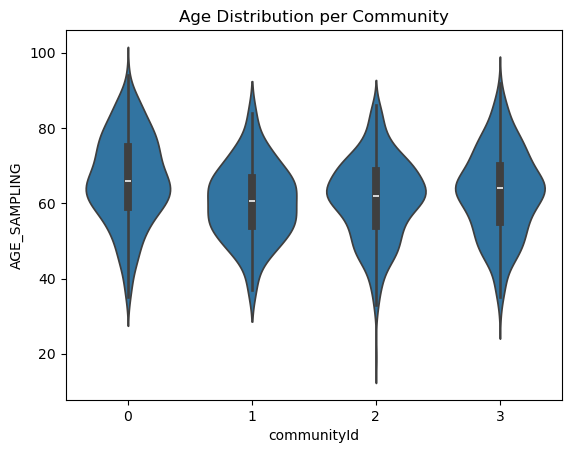

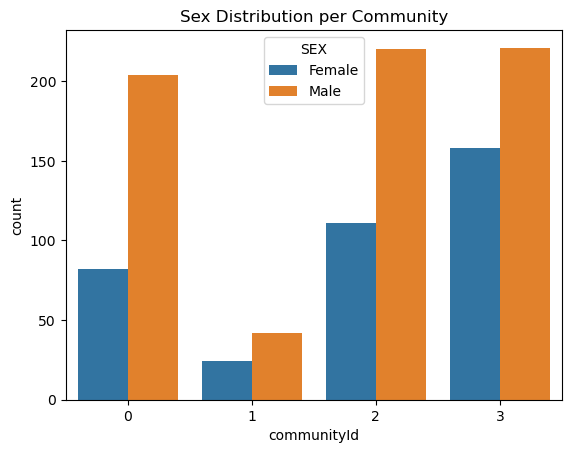

In [349]:
demographic_summary(merged_df)

In [350]:
import plotly.express as px
import plotly.graph_objects as go


def compare_age_mutation_count(merged_df, comm1, comm2):

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([comm1, comm2])], y='AGE_SAMPLING', x='communityId', box=True, points='all',
                        title='Violin Plot of AGE_SAMPLING by Community')
    fig_violin.show()

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([0,1,2,3])], y='MUTATION_COUNT', x='communityId', box=True, points='all',
                        title='Violin Plot of MUTATION_COUNT by Community')
    fig_violin.show()

    # 2. KDE plot for AGE_SAMPLING for communities 1 and 2
    from scipy.stats import gaussian_kde

    # Filter data for communities 1 and 2
    df_1 = merged_df[merged_df['communityId'] == comm1]['AGE_SAMPLING']
    df_2 = merged_df[merged_df['communityId'] == comm2]['AGE_SAMPLING']

    # Generate KDEs
    kde_1 = gaussian_kde(df_1)
    kde_2 = gaussian_kde(df_2)

    x_vals = np.linspace(merged_df['AGE_SAMPLING'].min(), merged_df['AGE_SAMPLING'].max(), 200)
    y_1 = kde_1(x_vals)
    y_2 = kde_2(x_vals)

    # Create KDE plot
    fig_kde = go.Figure()
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_1, mode='lines', name=f'Community {comm1}'))
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_2, mode='lines', name=f'Community {comm2}'))
    fig_kde.update_layout(title=f'KDE Plot of AGE_SAMPLING for Communities {comm1} and {comm2}',
                        xaxis_title='AGE_SAMPLING',
                        yaxis_title='Density')
    fig_kde.show()

In [351]:
compare_age_mutation_count(merged_df, 0, 1)

In [352]:
compare_age_mutation_count(merged_df, 1, 2)

In [353]:
compare_age_mutation_count(merged_df, 2, 3)

In [354]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated  unmutated
communityId                              
0                     0.333333   0.666667
1                     0.500000   0.500000
2                     0.412308   0.587692
3                     0.762032   0.237968


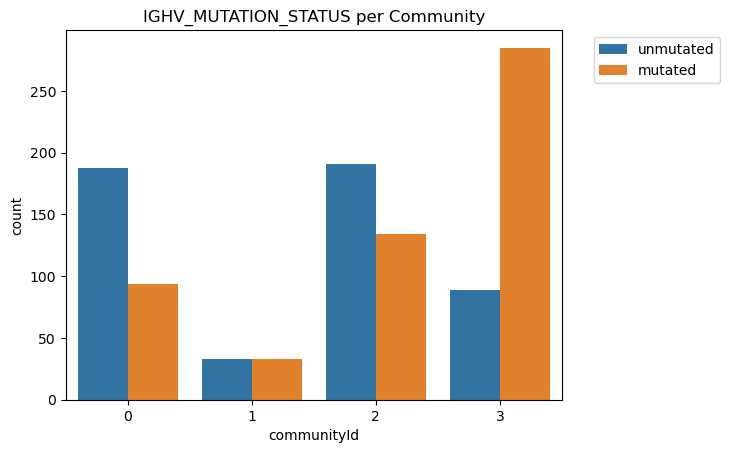


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL  unclassified
communityId                                            
0            0.101399  0.223776  0.580420      0.094406
1            0.106061  0.272727  0.287879      0.333333
2            0.154079  0.232628  0.465257      0.148036
3            0.155673  0.525066  0.171504      0.147757


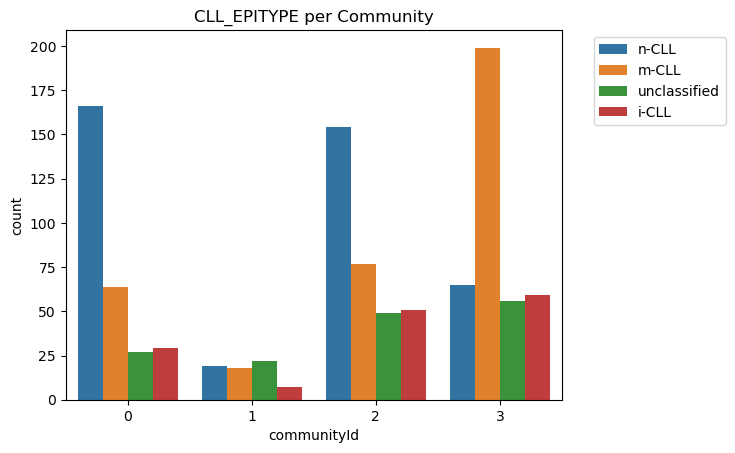


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL
communityId                                
0                        0.478088  0.521912
1                        0.704918  0.295082
2                        0.552542  0.447458
3                        0.551613  0.448387


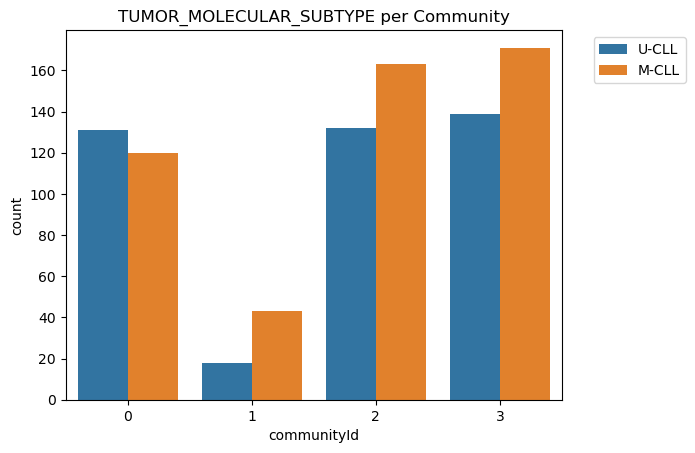


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.003497    0.052448       0.038462  0.000000   
1                              0.000000    0.000000       0.030303  0.000000   
2                              0.003021    0.036254       0.018127  0.003021   
3                              0.002639    0.026385       0.021108  0.000000   

PRIOR_TREATMENT_CATEGORY   Rel/Ref  Untreated  
communityId                                    
0                         0.020979   0.884615  
1                         0.000000   0.969697  
2                         0.036254   0.903323  
3                         0.010554   0.939314  


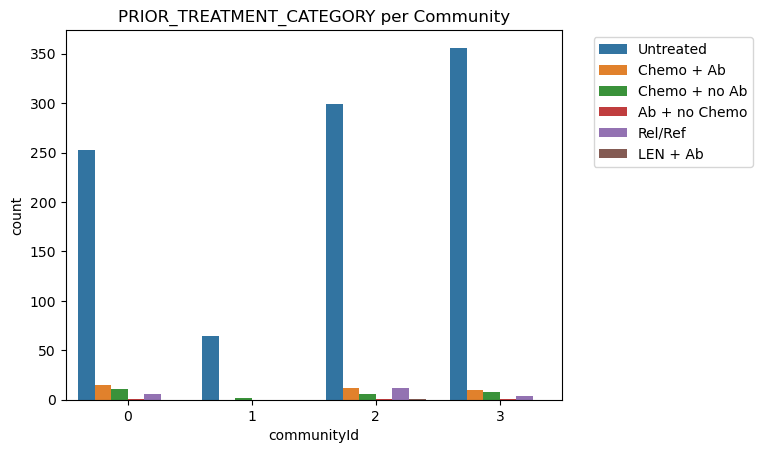


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.067164   0.000000    0.000000      0.007463   
1                              0.030769   0.000000    0.000000      0.000000   
2                              0.043011   0.005376    0.005376      0.005376   
3                              0.062500   0.000000    0.000000      0.031250   

TREATMENT_AFTER_SAMPLING  BCL2 inhibitor  BTK + chemo + Ab  BTK inhibitor  \
communityId                                                                 
0                               0.007463          0.000000       0.007463   
1                               0.000000          0.000000       0.000000   
2                               0.005376          0.010753       0.069892   
3                               0.000000          0.000000       0.062500   


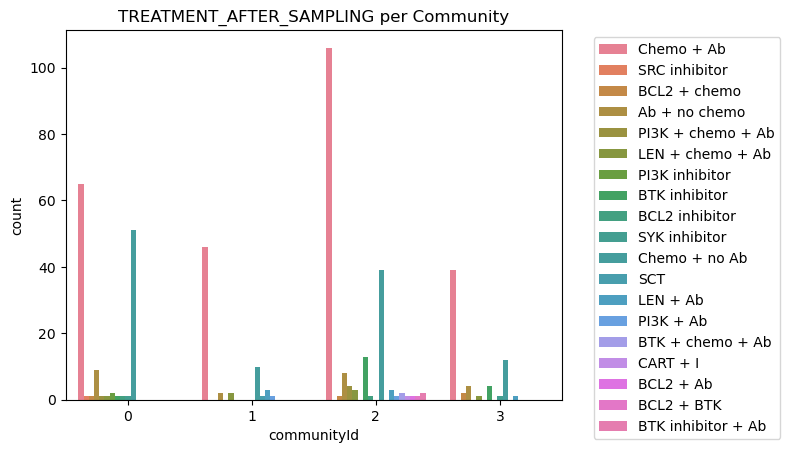

In [355]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)

In [356]:
def get_treatment_stats_by_community(df, community_id):
    # Filter the dataframe for the given community
    community_df = df[df['communityId'] == community_id]

    # Total number of patients in the community
    total_patients = len(community_df)

    # Group by TREATMENT_AFTER_SAMPLING and count occurrences including NaN
    treatment_counts = community_df['TREATMENT_AFTER_SAMPLING'].value_counts(dropna=False)

    # Create a list of dictionaries with treatment, count, and percentage
    treatment_stats = []
    for treatment, count in treatment_counts.items():
        treatment_stats.append({
            'TREATMENT_AFTER_SAMPLING': treatment,
            '#patients': count,
            '%patients': round((count / total_patients) * 100, 2)
        })

    # Sort the list by percentage of patients in descending order
    treatment_stats_sorted = sorted(treatment_stats, key=lambda x: x['%patients'], reverse=True)

    return treatment_stats_sorted

In [357]:
treatment_0 = get_treatment_stats_by_community(merged_df, 0)
treatment_0

[{'TREATMENT_AFTER_SAMPLING': nan, '#patients': 152, '%patients': 53.15},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
  '#patients': 65,
  '%patients': 22.73},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
  '#patients': 51,
  '%patients': 17.83},
 {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
  '#patients': 9,
  '%patients': 3.15},
 {'TREATMENT_AFTER_SAMPLING': 'PI3K inhibitor',
  '#patients': 2,
  '%patients': 0.7},
 {'TREATMENT_AFTER_SAMPLING': 'SRC inhibitor',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'PI3K + chemo + Ab',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'BCL2 inhibitor',
  '#patients': 1,
  '%patients': 0.35},
 {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
 

In [358]:
treatment_1 = get_treatment_stats_by_community(merged_df, 1)
treatment_1

[{'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
  '#patients': 46,
  '%patients': 69.7},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
  '#patients': 10,
  '%patients': 15.15},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + Ab', '#patients': 3, '%patients': 4.55},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
  '#patients': 2,
  '%patients': 3.03},
 {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
  '#patients': 2,
  '%patients': 3.03},
 {'TREATMENT_AFTER_SAMPLING': 'SCT', '#patients': 1, '%patients': 1.52},
 {'TREATMENT_AFTER_SAMPLING': 'PI3K + Ab', '#patients': 1, '%patients': 1.52},
 {'TREATMENT_AFTER_SAMPLING': nan, '#patients': 1, '%patients': 1.52}]

In [359]:
treatment_2 = get_treatment_stats_by_community(merged_df, 2)
treatment_2

[{'TREATMENT_AFTER_SAMPLING': nan, '#patients': 145, '%patients': 43.81},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
  '#patients': 106,
  '%patients': 32.02},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
  '#patients': 39,
  '%patients': 11.78},
 {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
  '#patients': 13,
  '%patients': 3.93},
 {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
  '#patients': 8,
  '%patients': 2.42},
 {'TREATMENT_AFTER_SAMPLING': 'PI3K + chemo + Ab',
  '#patients': 4,
  '%patients': 1.21},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
  '#patients': 3,
  '%patients': 0.91},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + Ab', '#patients': 3, '%patients': 0.91},
 {'TREATMENT_AFTER_SAMPLING': 'BTK + chemo + Ab',
  '#patients': 2,
  '%patients': 0.6},
 {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor + Ab',
  '#patients': 2,
  '%patients': 0.6},
 {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo',
  '#patients': 1,
  '%patients': 0.3},
 {'TREATMENT_AFTER_SAMPLING': 'PI3K + Ab', '#patien

In [360]:
treatment_3 = get_treatment_stats_by_community(merged_df, 3)
treatment_3

[{'TREATMENT_AFTER_SAMPLING': nan, '#patients': 315, '%patients': 83.11},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
  '#patients': 39,
  '%patients': 10.29},
 {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
  '#patients': 12,
  '%patients': 3.17},
 {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
  '#patients': 4,
  '%patients': 1.06},
 {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
  '#patients': 4,
  '%patients': 1.06},
 {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo',
  '#patients': 2,
  '%patients': 0.53},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
  '#patients': 1,
  '%patients': 0.26},
 {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
  '#patients': 1,
  '%patients': 0.26},
 {'TREATMENT_AFTER_SAMPLING': 'LEN + Ab', '#patients': 1, '%patients': 0.26}]

In [361]:
# Function to compare two communities
def compare_two_communities_for_treatment(data, id1, id2):
    set1 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id1]}
    set2 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    return common, unique_to_id1, unique_to_id2

In [362]:
treatment_data = {
    0: treatment_0,
    1: treatment_1,
    2: treatment_2,
    3: treatment_3
}

In [363]:
common_0_1, unique_0, unique_1 = compare_two_communities_for_treatment(treatment_data, 0, 1)
print("Common treatments between community 0 and 1:", common_0_1)
print("Unique to community 0:", unique_0)
print("Unique to community 1:", unique_1)

Common treatments between community 0 and 1: {nan, 'Ab + no chemo', 'Chemo + Ab', 'Chemo + no Ab', 'LEN + chemo + Ab'}
Unique to community 0: {'SYK inhibitor', 'BCL2 + chemo', 'PI3K + chemo + Ab', 'BTK inhibitor', 'PI3K inhibitor', 'BCL2 inhibitor', 'SRC inhibitor'}
Unique to community 1: {'PI3K + Ab', 'LEN + Ab', 'SCT'}


In [364]:
common_1_2, unique_1, unique_2 = compare_two_communities_for_treatment(treatment_data, 1, 2)
print("Common treatments between community 1 and 2:", common_1_2)
print("Unique to community 1:", unique_1)
print("Unique to community 2:", unique_2)

Common treatments between community 1 and 2: {nan, 'Ab + no chemo', 'Chemo + Ab', 'Chemo + no Ab', 'PI3K + Ab', 'LEN + chemo + Ab', 'LEN + Ab'}
Unique to community 1: {'SCT'}
Unique to community 2: {'CART + I', 'BCL2 + chemo', 'PI3K + chemo + Ab', 'BTK inhibitor + Ab', 'BTK inhibitor', 'BCL2 inhibitor', 'BTK + chemo + Ab', 'BCL2 + Ab', 'BCL2 + BTK'}


In [365]:
common_2_3, unique_2, unique_3 = compare_two_communities_for_treatment(treatment_data, 2, 3)
print("Common treatments between community 2 and 3:", common_2_3)
print("Unique to community 2:", unique_2)
print("Unique to community 3:", unique_3)

Common treatments between community 2 and 3: {nan, 'BCL2 + chemo', 'Ab + no chemo', 'Chemo + Ab', 'Chemo + no Ab', 'BTK inhibitor', 'LEN + chemo + Ab', 'LEN + Ab'}
Unique to community 2: {'CART + I', 'PI3K + chemo + Ab', 'BTK inhibitor + Ab', 'BCL2 inhibitor', 'BTK + chemo + Ab', 'PI3K + Ab', 'BCL2 + Ab', 'BCL2 + BTK'}
Unique to community 3: {'SYK inhibitor'}


In [366]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER']
# clinical_summary(merged_df, clinical_features)

In [367]:
clinical_features = ['COHORT','originId', 'originType']
# clinical_summary(merged_df, clinical_features)

In [368]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())
        
        sns.violinplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()


🔬 MUTATION_COUNT distribution per community:

             count       mean        std  min   25%   50%    75%    max
communityId                                                            
0            255.0  34.835294  31.734819  7.0  21.0  29.0  40.00  320.0
1             63.0  42.587302  79.898451  4.0  18.5  26.0  36.00  556.0
2            312.0  29.554487  23.977822  4.0  19.0  25.0  32.25  310.0
3            344.0  26.718023  24.063306  4.0  17.0  23.0  30.00  331.0


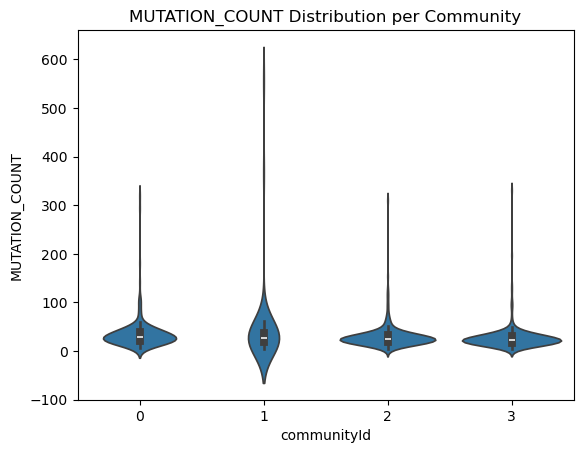

In [369]:
clinical_numeric_features = ['MUTATION_COUNT']#  'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
clinical_numeric_summary(merged_df, clinical_numeric_features)

## Mutations

In [370]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [371]:
mutation_annotated.shape

(29526, 22)

In [372]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

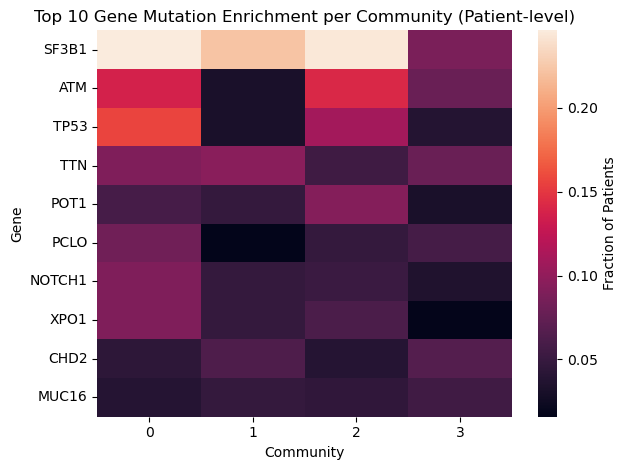

In [373]:
mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [374]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()


In [375]:
small_categorical_features = ['mutationType', 'variantType']
# plot_small_categoricals(mutation_annotated, small_categorical_features)

In [376]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    top_mutations = {}
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        top_mutations[cid] = []
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
            top_mutations[cid].append({col: val, 'Percentage': round(pct, 2)})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))

    return top_mutations
    
    # # Plot: Stacked bar, only top N per community, percentage of patients
    # plot_df = pd.DataFrame(plot_data)
    # pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    # ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    # plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    # plt.ylabel("% of Patients in Community")
    # plt.xlabel("Community")
    # plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    
    # # Annotate percentages on bars
    # for i, (idx, row) in enumerate(pivot.iterrows()):
    #     cumm = 0
    #     for j, val in enumerate(row):
    #         if val > 0:
    #             plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
    #             cumm += val
    # plt.show()

In [377]:
top_mutations = top_values_by_community(mutation_annotated, 'hugoGeneSymbol', top_n=10)
top_mutations


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,AHNAK,ATM,BRAF,CHD2,CSMD1,CSMD3,EGR2,FAT1,KLHL6,KRAS,...,NOTCH1,PCLO,POT1,SF3B1,TP53,TTN,USH2A,XPO1,ZFHX4,ZMYM3
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,13.67,6.25,0.00,0.00,0.00,5.86,0.00,0.00,0.00,...,8.98,8.20,5.86,24.61,15.62,8.98,0.00,8.98,0.00,0.00
1,7.94,0.00,0.00,0.00,7.94,7.94,0.00,7.94,0.00,7.94,...,0.00,0.00,0.00,22.22,0.00,9.52,7.94,0.00,0.00,7.94
2,0.00,14.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.13,...,5.13,0.00,9.29,24.36,10.90,5.45,0.00,6.09,5.13,0.00
3,0.00,7.85,0.00,6.69,0.00,5.81,0.00,0.00,5.52,0.00,...,0.00,5.81,0.00,8.72,0.00,7.85,0.00,0.00,0.00,0.00


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(24.61)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(15.62)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(13.67)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(8.2)},
  {'hugoGeneSymbol': 'BRAF', 'Percentage': np.float64(6.25)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(5.86)},
  {'hugoGeneSymbol': 'EGR2', 'Percentage': np.float64(5.86)}],
 1: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(22.22)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(9.52)},
  {'hugoGeneSymbol': 'ZMYM3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD1', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'USH2A', 'Percentage': np.float64(7

In [378]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from upsetplot import UpSet


# Function to compare two communities
def compare_two_communities(data, id1, id2):
    set1 = {gene['hugoGeneSymbol'] for gene in data[id1]}
    set2 = {gene['hugoGeneSymbol'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    return common, unique_to_id1, unique_to_id2

# Function to compare all four communities
def compare_all_communities(data):
    sets = [set(gene['hugoGeneSymbol'] for gene in data[i]) for i in range(4)]
    common_all = set.intersection(*sets)
    unique_all = [s - set.union(*(sets[:i] + sets[i+1:])) for i, s in enumerate(sets)]
    return common_all, unique_all

In [379]:
common_0_1, unique_0, unique_1 = compare_two_communities(top_mutations, 0, 1)
print("Common mutations between community 0 and 1:", common_0_1)
print("Unique to community 0:", unique_0)
print("Unique to community 1:", unique_1)

Common mutations between community 0 and 1: {'TTN', 'SF3B1'}
Unique to community 0: {'ATM', 'XPO1', 'BRAF', 'POT1', 'EGR2', 'NOTCH1', 'TP53', 'PCLO'}
Unique to community 1: {'USH2A', 'AHNAK', 'MYD88', 'FAT1', 'CSMD1', 'CSMD3', 'ZMYM3', 'KRAS'}


In [380]:
common_1_2, unique_1, unique_2 = compare_two_communities(top_mutations, 1, 2)
print("Common mutations between community 1 and 2:", common_1_2)
print("Unique to community 1:", unique_1)
print("Unique to community 2:", unique_2)

Common mutations between community 1 and 2: {'TTN', 'SF3B1', 'KRAS'}
Unique to community 1: {'USH2A', 'AHNAK', 'MYD88', 'FAT1', 'CSMD1', 'CSMD3', 'ZMYM3'}
Unique to community 2: {'ATM', 'XPO1', 'POT1', 'ZFHX4', 'NOTCH1', 'TP53', 'LRP1B'}


In [381]:
common_2_3, unique_2, unique_3 = compare_two_communities(top_mutations, 2, 3)
print("Common mutations between community 2 and 3:", common_2_3)
print("Unique to community 2:", unique_2)
print("Unique to community 3:", unique_3)

Common mutations between community 2 and 3: {'TTN', 'ATM', 'SF3B1', 'LRP1B'}
Unique to community 2: {'XPO1', 'POT1', 'ZFHX4', 'NOTCH1', 'TP53', 'KRAS'}
Unique to community 3: {'CHD2', 'MUC16', 'KLHL6', 'MYD88', 'CSMD3', 'PCLO'}


In [382]:
common_all, unique_all = compare_all_communities(top_mutations)
print("Common mutations in all communities:", common_all)
print("Unique mutations in each community:", unique_all)

Common mutations in all communities: {'TTN', 'SF3B1'}
Unique mutations in each community: [{'BRAF', 'EGR2'}, {'USH2A', 'AHNAK', 'FAT1', 'CSMD1', 'ZMYM3'}, {'ZFHX4'}, {'CHD2', 'KLHL6', 'MUC16'}]


{0: ['SF3B1', 'TP53', 'ATM', 'NOTCH1', 'TTN', 'XPO1', 'PCLO', 'BRAF', 'POT1', 'EGR2'], 1: ['SF3B1', 'TTN', 'ZMYM3', 'CSMD3', 'CSMD1', 'USH2A', 'FAT1', 'AHNAK', 'KRAS', 'MYD88'], 2: ['SF3B1', 'ATM', 'TP53', 'POT1', 'XPO1', 'LRP1B', 'TTN', 'ZFHX4', 'KRAS', 'NOTCH1'], 3: ['SF3B1', 'TTN', 'ATM', 'CHD2', 'PCLO', 'CSMD3', 'MUC16', 'KLHL6', 'MYD88', 'LRP1B']}


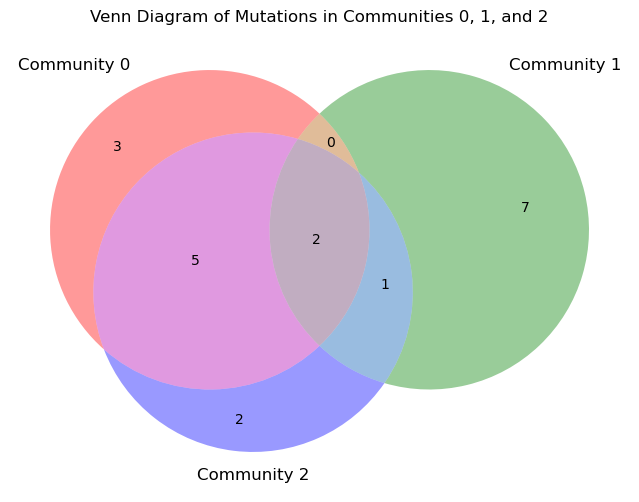

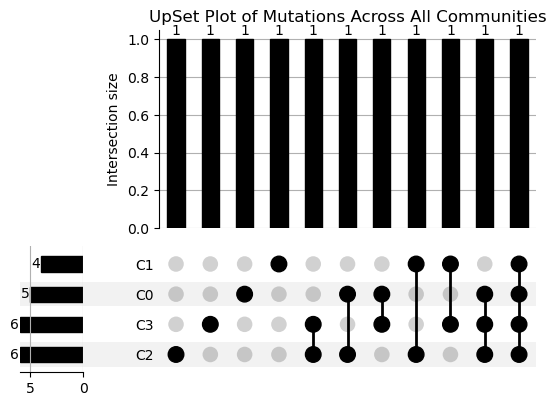

In [383]:
# Create sets for communities 0, 1, 2
mutation_data = {}
for i in range(4):
    mutation_data[i] = [i['hugoGeneSymbol'] for i in top_mutations[i]]

print(mutation_data)

set0 = set(mutation_data[0])
set1 = set(mutation_data[1])
set2 = set(mutation_data[2])

# Plot Venn diagram for communities 0, 1, 2
plt.figure(figsize=(8, 6))
venn3([set0, set1, set2], set_labels=('Community 0', 'Community 1', 'Community 2'))
plt.title("Venn Diagram of Mutations in Communities 0, 1, and 2")
plt.show()

# Prepare data for UpSet plot for all four communities
all_genes = set.union(*[set(mutation_data[i]) for i in range(4)])
data = []

for gene in all_genes:
    presence = tuple(gene in mutation_data[i] for i in range(4))
    data.append(presence)

# Create a DataFrame for UpSet plot
df = pd.DataFrame(data, columns=['C0', 'C1', 'C2', 'C3'])
df['count'] = 1
df = df.groupby(['C0', 'C1', 'C2', 'C3']).count()

# Plot UpSet plot
upset = UpSet(df, subset_size='count', show_counts=True)
upset.plot()
plt.title("UpSet Plot of Mutations Across All Communities")
plt.show()


In [384]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
# for col in columns_to_analyze:
#     top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [385]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()

In [386]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
# numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

## Community 3 dissection

In [387]:
community_3 = merged_df[merged_df['communityId'] == 3]
mutation_3 = mutation_annotated[mutation_annotated['communityId'] == 3]
community_3.shape

(379, 32)

In [388]:
failed_community_3 = community_3[community_3['FFS_STATUS_EVENT'] == 1]
failure_free_community_3 =  community_3[community_3['FFS_STATUS_EVENT'] == 0]
failed_community_3.shape

(7, 32)

In [389]:
failed_community_3['FFS_MONTHS']

23     146.04
25     128.38
97     137.46
603    134.17
708    141.70
803    119.18
851    163.46
Name: FFS_MONTHS, dtype: float64

In [390]:
# 1. Violin plot of AGE_SAMPLING grouped by community
fig_violin = px.violin(community_3, y='AGE_SAMPLING', x='FFS_STATUS_EVENT', box=True, points='all',
                    title='Violin Plot of AGE_SAMPLING by FFS_STATUS_EVENT')
fig_violin.show()

# 1. Violin plot of AGE_SAMPLING grouped by community
fig_violin = px.violin(community_3, y='MUTATION_COUNT', x='FFS_STATUS_EVENT', box=True, points='all',
                    title='Violin Plot of MUTATION_COUNT by FFS_STATUS_EVENT')
fig_violin.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated  unmutated
FFS_STATUS_EVENT                         
0                     0.760218   0.239782
1                     0.857143   0.142857


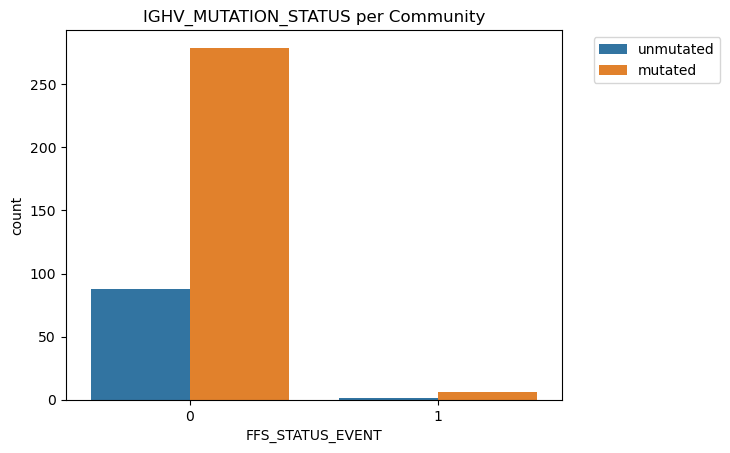


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE          i-CLL     m-CLL     n-CLL  unclassified
FFS_STATUS_EVENT                                            
0                 0.155914  0.521505  0.174731      0.147849
1                 0.142857  0.714286  0.000000      0.142857


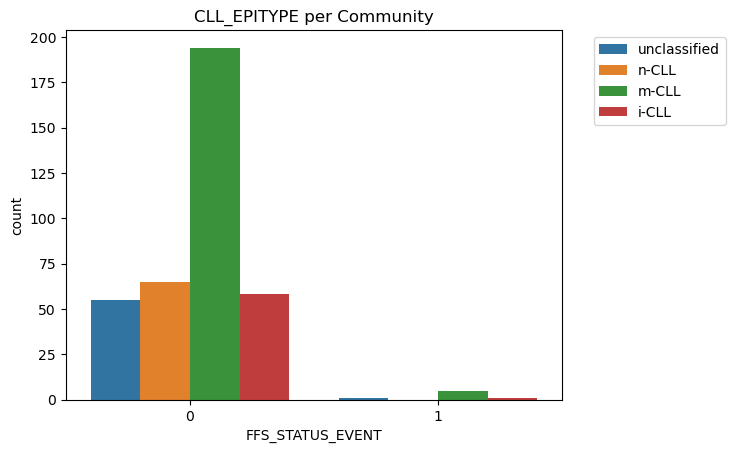


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL
FFS_STATUS_EVENT                           
0                        0.544554  0.455446
1                        0.857143  0.142857


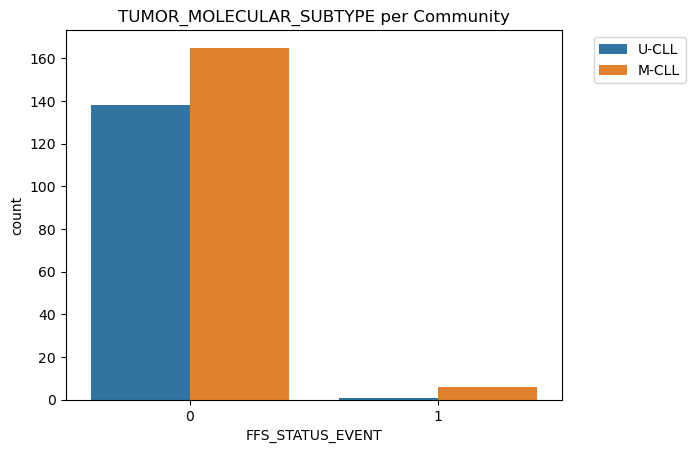


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + chemo  BTK inhibitor  \
FFS_STATUS_EVENT                                                       
0                              0.070175      0.035088       0.035088   
1                              0.000000      0.000000       0.285714   

TREATMENT_AFTER_SAMPLING  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
FFS_STATUS_EVENT                                                
0                           0.631579       0.192982  0.017544   
1                           0.428571       0.142857  0.000000   

TREATMENT_AFTER_SAMPLING  LEN + chemo + Ab  SYK inhibitor  
FFS_STATUS_EVENT                                           
0                                 0.000000       0.017544  
1                                 0.142857       0.000000  


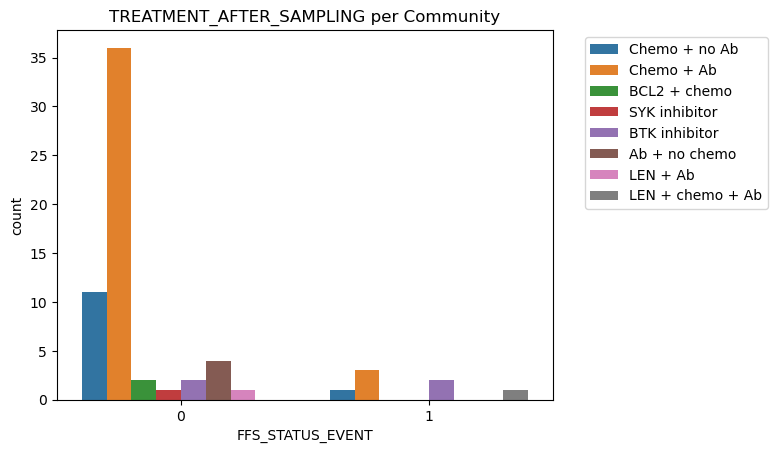

In [391]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(community_3, clinical_features, 'FFS_STATUS_EVENT')

In [392]:
import pandas as pd

# Assuming community_3 and mutations_3 DataFrames are already defined
# Merge the two DataFrames on 'patientId'
merged_mutation_3 = pd.merge(mutation_3, community_3[['patientId', 'FFS_STATUS_EVENT']], on='patientId')

mutations_data_3 = top_values_by_community(merged_mutation_3, 'hugoGeneSymbol', 'FFS_STATUS_EVENT', 10)
mutations_data_3


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,ATM,CHD2,CSMD3,FAT4,KLHL6,LRP1B,MUC16,MYD88,PCLO,RALYL,RBP3,RFC3,RGMA,RHCG,RPL26L1,SF3B1,SLC22A15,TTN,VWF
Community,,,,,,,,,,,,,,,,,,,
0,7.69,6.8,5.92,0.00,5.62,4.44,5.62,5.33,5.33,0.00,0.00,0.00,0.00,0.00,0.00,8.58,0.00,7.99,0.00
1,0.00,0.0,0.00,33.33,0.00,0.00,0.00,0.00,33.33,16.67,16.67,16.67,16.67,16.67,16.67,0.00,33.33,0.00,33.33


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(8.58)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(7.99)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(7.69)},
  {'hugoGeneSymbol': 'CHD2', 'Percentage': np.float64(6.8)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(5.92)},
  {'hugoGeneSymbol': 'MUC16', 'Percentage': np.float64(5.62)},
  {'hugoGeneSymbol': 'KLHL6', 'Percentage': np.float64(5.62)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(5.33)},
  {'hugoGeneSymbol': 'MYD88', 'Percentage': np.float64(5.33)},
  {'hugoGeneSymbol': 'LRP1B', 'Percentage': np.float64(4.44)}],
 1: [{'hugoGeneSymbol': 'FAT4', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'SLC22A15', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'VWF', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'RALYL', 'Percentage': np.float64(16.67)},
  {'hugoGeneSymbol': 'RPL26L1', 'Percentage': np.fl

In [393]:
common_0_1, unique_0, unique_1 = compare_two_communities(mutations_data_3, 0, 1)
print("Common mutations between community 3: ffs-0 and ffs-1:", common_0_1)
print("Unique to community 3 ffs-0:", unique_0)
print("Unique to community 3 ffs-1:", unique_1)

Common mutations between community 3: ffs-0 and ffs-1: {'PCLO'}
Unique to community 3 ffs-0: {'ATM', 'CHD2', 'MUC16', 'KLHL6', 'TTN', 'MYD88', 'CSMD3', 'LRP1B', 'SF3B1'}
Unique to community 3 ffs-1: {'SLC22A15', 'RPL26L1', 'RHCG', 'RGMA', 'RFC3', 'VWF', 'RALYL', 'FAT4', 'RBP3'}


In [394]:
treatments_data_3 = top_values_by_community(community_3, 'TREATMENT_AFTER_SAMPLING', 'FFS_STATUS_EVENT', 10)
treatments_data_3


🔎 Top 10 values of 'TREATMENT_AFTER_SAMPLING' per community (percentage of patients with at least one TREATMENT_AFTER_SAMPLING):


TREATMENT_AFTER_SAMPLING,Ab + no chemo,BCL2 + chemo,BTK inhibitor,Chemo + Ab,Chemo + no Ab,LEN + Ab,LEN + chemo + Ab,SYK inhibitor
Community,,,,,,,,
0,1.08,0.54,0.54,9.68,2.96,0.27,0.00,0.27
1,0.00,0.00,28.57,42.86,14.29,0.00,14.29,0.00


{0: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   'Percentage': np.float64(9.68)},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Percentage': np.float64(2.96)},
  {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
   'Percentage': np.float64(1.08)},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo', 'Percentage': np.float64(0.54)},
  {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
   'Percentage': np.float64(0.54)},
  {'TREATMENT_AFTER_SAMPLING': 'LEN + Ab', 'Percentage': np.float64(0.27)},
  {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
   'Percentage': np.float64(0.27)}],
 1: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   'Percentage': np.float64(42.86)},
  {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
   'Percentage': np.float64(28.57)},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Percentage': np.float64(14.29)},
  {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
   'Percentage': np.float64(14.29)}]}

In [395]:
common_0_1, unique_0, unique_1 = compare_two_communities_for_treatment(treatments_data_3, 0, 1)
print("Common treatments between community 3: ffs-0 and ffs-1:", common_0_1)
print("Unique to community 3 ffs-0:", unique_0)
print("Unique to community 3 ffs-1:", unique_1)

Common treatments between community 3: ffs-0 and ffs-1: {'Chemo + Ab', 'Chemo + no Ab', 'BTK inhibitor'}
Unique to community 3 ffs-0: {'SYK inhibitor', 'BCL2 + chemo', 'Ab + no chemo', 'LEN + Ab'}
Unique to community 3 ffs-1: {'LEN + chemo + Ab'}


## Survival analysis

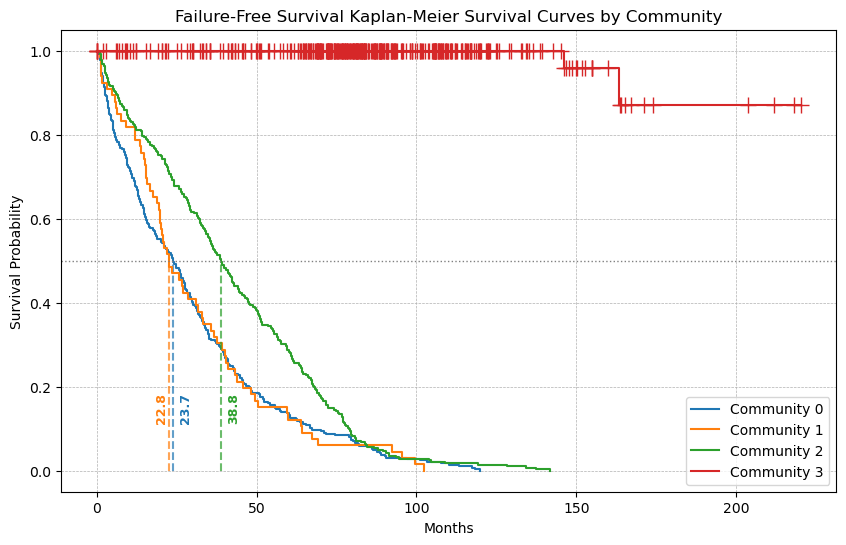

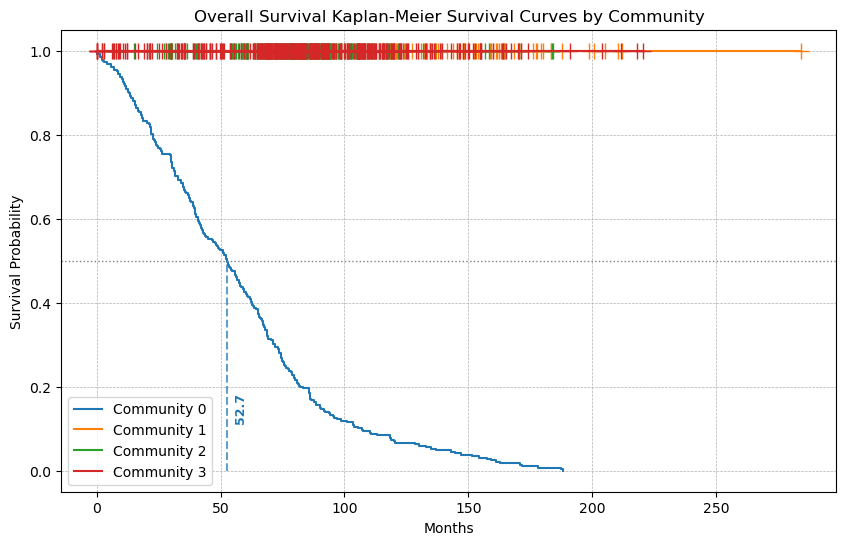

In [396]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()
    df = df.drop_duplicates(subset='patientId', keep='first')

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    median_times = {}

    for idx, (name, grouped_df) in enumerate(df.groupby('communityId')):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False, show_censors=True, ax=ax)
        median_time = kmf.median_survival_time_
        median_times[name] = median_time
        if not pd.isna(median_time):
            color = ax.get_lines()[-1].get_color()
            # Draw vertical line from (median_time, 0) to (median_time, 0.5)
            plt.plot([median_time, median_time], [0, 0.5], linestyle='--', color=color, alpha=0.7)
            # Alternate annotation side to avoid overlap
            if idx % 2 == 0:
                ha = 'right'
                offset = (14, 0)
            else:
                ha = 'left'
                offset = (-10, 0)
            plt.annotate(f"{median_time:.1f}",
                        xy=(median_time, 0.15), xytext=offset,
                        textcoords='offset points', ha=ha, va='center',
                        color=color, fontsize=9, fontweight='bold', rotation=90)
    # Draw horizontal line at 0.5 survival probability
    plt.axhline(0.5, color='grey', linestyle=':', linewidth=1)
    
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    
    # Set ticks at every 10 units
    max_time = df[time_col].max()
    plt.xticks()
    plt.yticks()

    # Add grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if time_col == 'FFS_MONTHS':
        plt.savefig("../../figures/survival_curves.png", dpi = 300)
    else:
        plt.savefig("../../figures/os_survival_curves.png", dpi = 300)
    plt.show()

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

In [397]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

def survival_km_with_stats(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')
    print(df['communityId'].value_counts())

    median_survival_times = {}
    df_median_times = {}
    df_mean_times = {}

    # Define time points for restricted mean survival time
    time_points = [float('inf'), 3, 5, 10]
    mean_survival_times_by_t = {f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)': {} for t in time_points}

    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col])

        # Median survival time from Kaplan-Meier curve
        median_survival_times[name] = kmf.median_survival_time_

        # Mean survival time using area under the curve at different time points
        for t in time_points:
            label_t = f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)'
            new_t = t if t == float('inf') else t*12
            mean_survival_times_by_t[label_t][name] = restricted_mean_survival_time(kmf, t=new_t)

        # Median and mean directly from the DataFrame
        df_median_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].median()
        df_mean_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].mean()

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'KM Median Survival Time': median_survival_times,
        'DF Median Survival Time': df_median_times,
        'DF Mean Survival Time': df_mean_times
    })

    # Add mean survival times at different t values
    for label, values in mean_survival_times_by_t.items():
        summary_df[label] = pd.Series(values)

    return summary_df



summary_ffs = survival_km_with_stats(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
summary_os = survival_km_with_stats(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

print("FFS")
display(summary_ffs)
print("OS")
display(summary_os)


communityId
3    374
0    286
2    282
1     66
Name: count, dtype: int64
communityId
3    374
0    286
2    282
1     66
Name: count, dtype: int64
FFS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,23.74,23.77,29.773951,29.773951,21.619580,26.616084,29.773951
1,22.75,22.67,30.698636,30.698636,23.154697,28.056667,30.698636
2,38.83,38.86,42.360887,42.360887,27.455957,37.108972,42.142057
3,inf,154.75,154.750000,inf,36.000000,60.000000,120.000000


OS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,52.7,52.7,57.191818,57.191818,30.450385,43.389266,54.877098
1,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
2,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
3,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


In [398]:
# Filter rows where FFS_EVENT is 1
filtered_df = merged_df[merged_df['FFS_STATUS_EVENT'] == 1]

# Find the row with the minimum FFS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['FFS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

# Find the row with the maximum FFS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['FFS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

     communityId  FFS_MONTHS
771            0        0.07
775            1        1.02
776            2        1.02
803            3      119.18
     communityId  FFS_MONTHS
682            0      119.74
29             1      102.25
707            2      141.70
934            3      220.30


In [399]:
# Filter rows where OS_EVENT is 1
filtered_df = merged_df[merged_df['OS_STATUS_EVENT'] == 1]

# Find the row with the minimum OS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['OS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

# Find the row with the maximum OS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['OS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

     communityId  OS_MONTHS
771            0       0.07
     communityId  OS_MONTHS
654            0     188.15
29             1     284.31
656            2     200.84
934            3     220.30


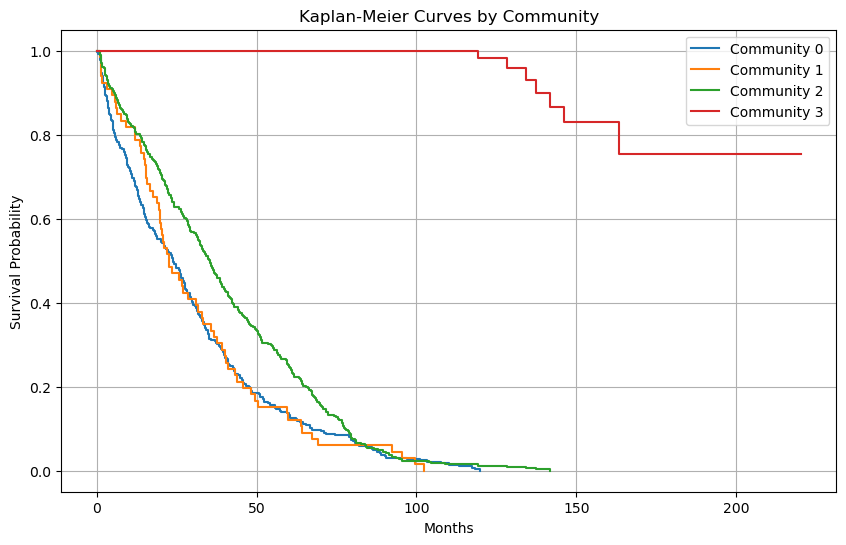

Log-Rank Test between Community 0 and 1: p = 0.9340571712263461
Log-Rank Test between Community 0 and 2: p = 0.0001218061235541513
Log-Rank Test between Community 0 and 3: p = 5.805436285676167e-180
Log-Rank Test between Community 1 and 2: p = 0.019294328058136707
Log-Rank Test between Community 1 and 3: p = 1.6423035939819026e-159
Log-Rank Test between Community 2 and 3: p = 6.892415583295533e-174


<lifelines.CoxPHFitter: fitted with 1062 total observations, 372 right-censored observations>
             duration col = 'FFS_MONTHS'
                event col = 'FFS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 690
   partial log-likelihood = -3811.83
         time fit was run = 2025-07-25 14:40:40 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
communityId_1 -0.01      0.99      0.14           -0.28            0.26                0.76                1.30
communityId_2 -0.32      0.72      0.08           -0.48           -0.16                0.62                0.85
communityId_3 -5.70      0.00      0.46           -6.59           -4.80                0.00                0.01

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00  -0.06   0.96      0.07
communityId_2    0.00  -3.98 <0.005     13.82
communityId_3    0.00 -12.50 <0.005    116.73
---
Concordance = 0.77
Partial AIC = 7629.65
log-likelihood ratio test = 1157.16 on 3 df
-log2(p) of ll-ratio test = 829.95

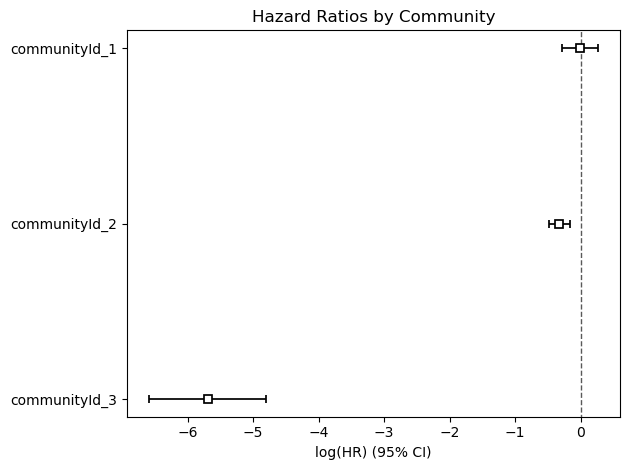

In [400]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['FFS_STATUS_EVENT'] = mod_df['FFS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['FFS_MONTHS'], group['FFS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['FFS_MONTHS'], group_b['FFS_MONTHS'],
                          event_observed_A=group_a['FFS_STATUS_EVENT'],
                          event_observed_B=group_b['FFS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='FFS_MONTHS', event_col='FFS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

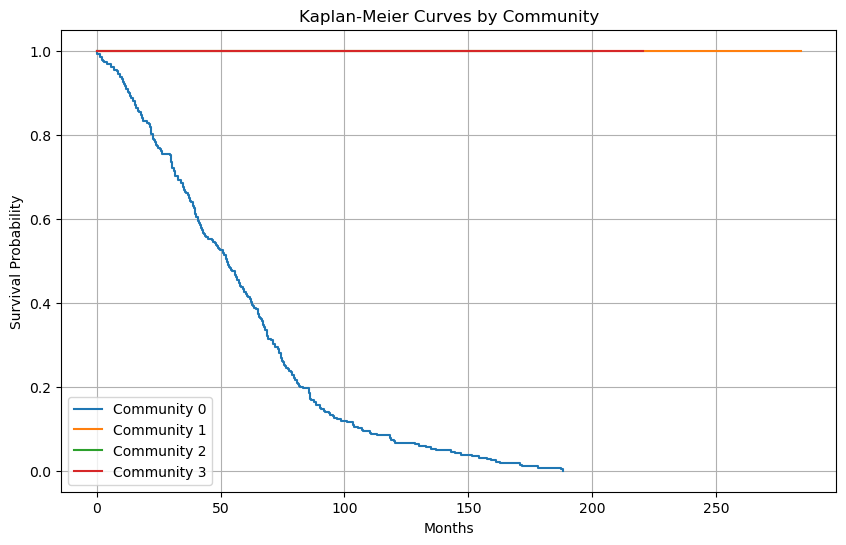

Log-Rank Test between Community 0 and 1: p = 2.4589868296521868e-45
Log-Rank Test between Community 0 and 2: p = 4.989543021903071e-125
Log-Rank Test between Community 0 and 3: p = 1.495987738359456e-136
Log-Rank Test between Community 1 and 2: p = 1.0
Log-Rank Test between Community 1 and 3: p = 1.0
Log-Rank Test between Community 2 and 3: p = 1.0


<lifelines.CoxPHFitter: fitted with 1062 total observations, 776 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 286
   partial log-likelihood = -1335.36
         time fit was run = 2025-07-25 14:40:40 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1 -21.54      0.00   3082.27        -6062.69         6019.60                0.00                 inf
communityId_2 -21.39      0.00   1816.20        -3581.08         3538.30                0.00                 inf
communityId_3 -21.40      0.00   1737.25        -3426.34         3383.55                0.00                 inf

               cmp to     z    p  -log2(p)
covariate                                 
communityId_1    0.00 -0.01 0.99      0.01
communityId_2    0.00 -0.01 0.99      0.01
communityId_3    0.00 -0.01 0.99      0.01
---
Concordance = 0.90
Partial AIC = 2676.72
log-likelihood ratio test = 1014.28 on 3 df
-log2(p) of ll-ratio test = 726.98

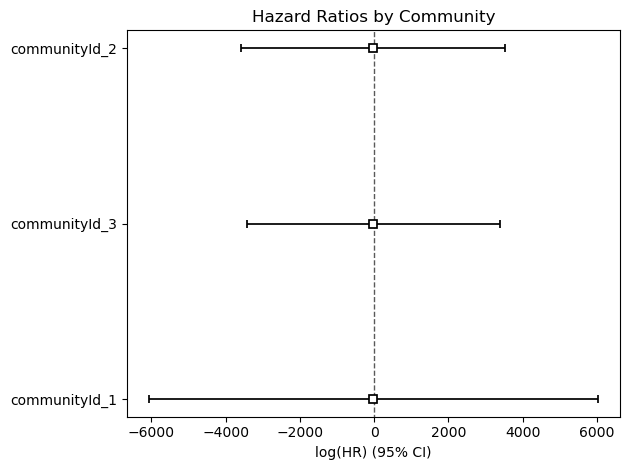

In [401]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['OS_STATUS_EVENT'] = mod_df['OS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['OS_MONTHS'], group['OS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['OS_MONTHS'], group_b['OS_MONTHS'],
                          event_observed_A=group_a['OS_STATUS_EVENT'],
                          event_observed_B=group_b['OS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='OS_MONTHS', event_col='OS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

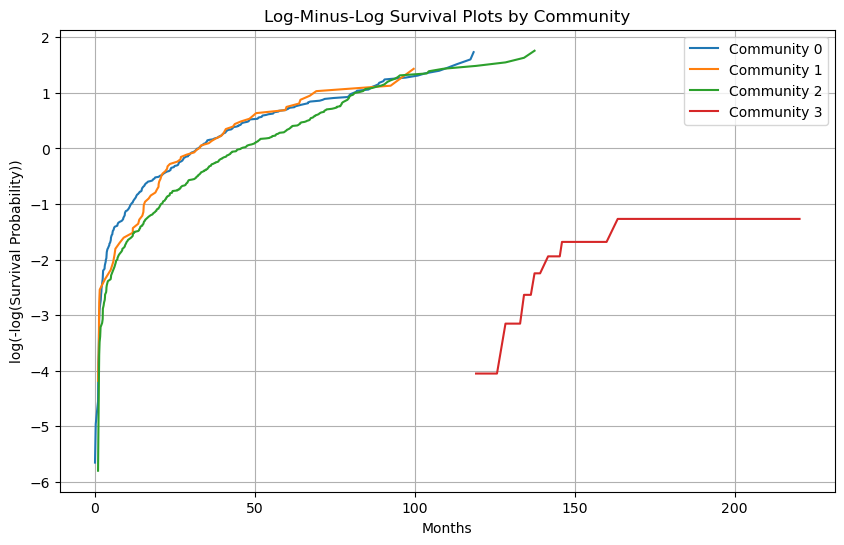

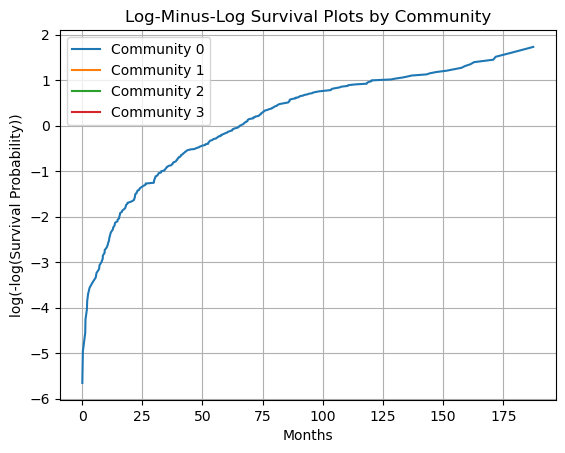

In [402]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Log-minus-log plots
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for label in ['FFS', 'OS']:
    for name, group in mod_df.groupby('communityId'):
        kmf.fit(group[f'{label}_MONTHS'], group[f'{label}_STATUS_EVENT'], label=f"Community {name}")
        survival_prob = kmf.survival_function_[f"Community {name}"]
        log_minus_log = np.log(-np.log(survival_prob))
        plt.plot(survival_prob.index, log_minus_log, label=f"Community {name}")

    plt.title("Log-Minus-Log Survival Plots by Community")
    plt.xlabel("Months")
    plt.ylabel("log(-log(Survival Probability))")
    plt.legend()
    plt.grid(True)
    plt.show()


## Extra

In [403]:
# 📌 SECTION 8: STATISTICAL TESTS
def run_statistical_tests(df, groupby='communityId'):
    print("\n📊 Kruskal-Wallis Test for AGE_SAMPLING:")
    groups = [group['AGE_SAMPLING'].dropna() for _, group in df.groupby(groupby)]
    print(kruskal(*groups))

    for feat in ['SEX', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']:
        print(f"\n📊 Chi-square Test for {feat}:")
        contingency = pd.crosstab(df[groupby], df[feat])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

run_statistical_tests(merged_df)


📊 Kruskal-Wallis Test for AGE_SAMPLING:
KruskalResult(statistic=np.float64(32.95858788276993), pvalue=np.float64(3.286106602716904e-07))

📊 Chi-square Test for SEX:
Chi2 = 12.76, p-value = 0.0052

📊 Chi-square Test for CLL_EPITYPE:
Chi2 = 169.44, p-value = 0.0000

📊 Chi-square Test for TUMOR_MOLECULAR_SUBTYPE:
Chi2 = 10.90, p-value = 0.0123


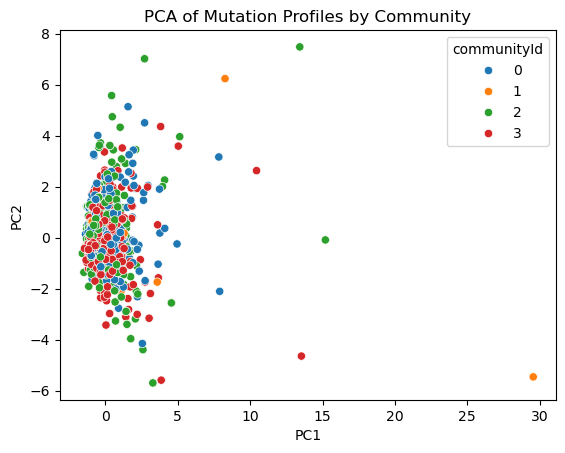

In [404]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

# Subset features (e.g., top 50 genes across all patients)
# pivot: patients x genes (1 if mutated, 0 otherwise)
mut = mutation_df.copy()
mut['mut_flag'] = 1
mut_matrix = mut.pivot_table(index='patientId', columns='hugoGeneSymbol', values='mut_flag', fill_value=0)

# Filter top 100 mutated genes
top_genes = mut['hugoGeneSymbol'].value_counts().head(100).index
mut_matrix = mut_matrix[top_genes.intersection(mut_matrix.columns)]

# Merge with community labels
feat_df = pd.merge(mut_matrix.reset_index(), community_df, on='patientId')

# Standardize and reduce
X = StandardScaler().fit_transform(feat_df[top_genes])
pca = PCA(n_components=2).fit_transform(X)
feat_df['PC1'], feat_df['PC2'] = pca[:,0], pca[:,1]

sns.scatterplot(data=feat_df, x='PC1', y='PC2', hue='communityId', palette='tab10')
plt.title("PCA of Mutation Profiles by Community")
plt.show()


In [405]:
# pip install gseapy
import gseapy as gp

gene_list = list(mut_matrix.columns[mut_matrix.sum() > 10])  # example threshold
enr = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2021_Human', outdir=None)
enr.results[['Term', 'Adjusted P-value', 'Overlap']]


,Term,Adjusted P-value,Overlap
0,Thyroid cancer,0.000090,5/37
1,Hepatitis B,0.000090,8/162
2,Bladder cancer,0.000090,5/41
3,Chronic myeloid leukemia,0.000090,6/76
4,Endometrial cancer,0.000337,5/58
...,...,...,...
158,Neutrophil extracellular trap formation,0.629424,1/189
159,Pathogenic Escherichia coli infection,0.641095,1/197
160,Diabetic cardiomyopathy,0.648343,1/203
161,Coronavirus disease,0.693794,1/232


## Visualisation

In [406]:
# get nodes table with community assignments and edges table with source, target, weight
from collections import Counter, defaultdict

# Step 1: Build mapping from patientId to all their communities
patient_to_comms = defaultdict(set)
for _, row in community_df.iterrows():
    patient_to_comms[row['patientId']].add(row['communityId'])

# Step 2: Assign new community IDs for overlaps
overlap_map = {}  # tuple of communities -> new communityId
next_overlap_id = max(community_df['communityId'].max() + 1, 4)  # start from 4 or next available

node_rows = []
for pid, comms in patient_to_comms.items():
    comms_tuple = tuple(sorted(comms))
    if len(comms_tuple) == 1:
        # Single community, keep as is
        node_rows.append({'nodeId': pid, 'communityId': comms_tuple[0]})
    else:
        # Overlapping, assign new communityId
        if comms_tuple not in overlap_map:
            overlap_map[comms_tuple] = next_overlap_id
            next_overlap_id += 1
        node_rows.append({'nodeId': pid, 'communityId': overlap_map[comms_tuple]})

nodes_df = pd.DataFrame(node_rows)

# Map patientId to nodeId using mapping_df as before
G = nx.read_gml(os.path.join(base_path, "graph.gml"), label='id')
mapping_df = pd.read_csv(os.path.join(base_path, "patient_id_mapping.csv"))
mapping_df['nodeId'] = mapping_df['nodeId'].astype(int)
mapping_dict = mapping_df.set_index('patientId')['nodeId'].to_dict()
nodes_df['Id'] = nodes_df['nodeId'].map(mapping_dict)

# Remove any rows with missing nodeId (if mapping is incomplete)
nodes_df = nodes_df.dropna(subset=['Id'])
nodes_df.drop(columns='nodeId', inplace=True)  # keep only Id and communityId

# Edges as before
edges_df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'data'])
edges_df['weight'] = edges_df['data'].apply(lambda x: x.get('weight', 1))  # default weight to 1 if not present
edges_df.drop(columns='data', inplace=True)

# Save nodes and edges to CSV for visualization
nodes_df.to_csv(os.path.join(base_path, algo, 'nodes.csv'), index=False)
edges_df.to_csv(os.path.join(base_path, algo, 'edges.csv'), index=False)

# Print mapping of overlaps for reference
print("Overlap group mapping (tuple of original communities -> new communityId):")
for k, v in overlap_map.items():
    print(f"{k} -> {v}")

Overlap group mapping (tuple of original communities -> new communityId):
(1, 2) -> 4
(2, 3) -> 5


In [407]:
resolved_df = nodes_df.copy(deep=True)
# if 4, but replace with 1, if 5 replace with 2
resolved_df['communityId'] = resolved_df['communityId'].replace({4: 1, 5: 2,})

# based on this new resolved_df and G, compute newman girvan modularity
from cdlib.evaluation import newman_girvan_modularity
from cdlib import NodeClustering
# Use the resolved_df to get communities
resolved_communities = resolved_df['communityId'].unique()

communities = {cid: set(resolved_df[resolved_df['communityId'] == cid]['Id']) for cid in resolved_communities}
communities_list = list(communities.values())
communities_node_clustering = NodeClustering(communities_list, G, method_name="SLPA_Leiden_Resolved")
modularity = newman_girvan_modularity(G, communities_node_clustering).score
print(f"Newman-Girvan Modularity: {modularity:.4f}")

Newman-Girvan Modularity: 0.6123
